In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df: pd.DataFrame = pd.read_csv("data/date-hour-soo-dest-2025.csv")

In [3]:
df.head()

,date,hour,from,to,swipes
0,2025-01-01,0,12TH,16TH,1
1,2025-01-01,0,12TH,ANTC,1
2,2025-01-01,0,12TH,BALB,1
3,2025-01-01,0,12TH,BERY,1
4,2025-01-01,0,12TH,CIVC,8


Make date a pd.DateTime

In [4]:
df["date"] = pd.to_datetime(df["date"])
df["day_of_week"] = df["date"].dt.day_of_week
df["month_num"] = df["date"].dt.month
df.head()

,date,hour,from,to,swipes,day_of_week,month_num
0,2025-01-01,0,12TH,16TH,1,2,1
1,2025-01-01,0,12TH,ANTC,1,2,1
2,2025-01-01,0,12TH,BALB,1,2,1
3,2025-01-01,0,12TH,BERY,1,2,1
4,2025-01-01,0,12TH,CIVC,8,2,1


Is there seasonality?

- For a month, average swipes, and see how that ranges
- For an hour, average swipes, and see how that ranges (daily trends)
- For each day of week, average swipes

In [5]:
def plot_seasonality(df: pd.DataFrame, title: str, xlabel: str, ylabel: str) -> None:
    fig, ax = plt.subplots(figsize=(12, 5))

    # Bar chart
    x = df.index
    ax.bar(x, df.values, alpha=0.6, color="steelblue", label="Average")

    # Connecting line
    ax.plot(
        x,
        df.values,
        "r-",
        linewidth=2,
        marker="o",
        markersize=6,
        label="Trend",
    )

    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    ax.grid(True, alpha=0.3, axis="y")
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

Average Swipes by Month

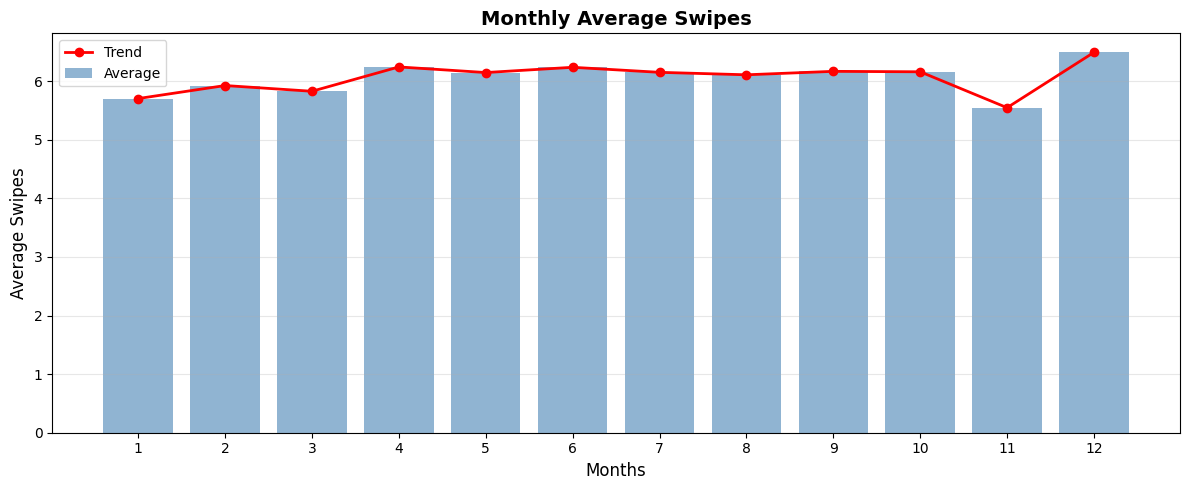

In [6]:
# my plotting code prefers the below implementation
monthly_avg_swipes = df.groupby("month_num")["swipes"].mean()
plot_seasonality(
    monthly_avg_swipes, "Monthly Average Swipes", "Months", "Average Swipes"
)

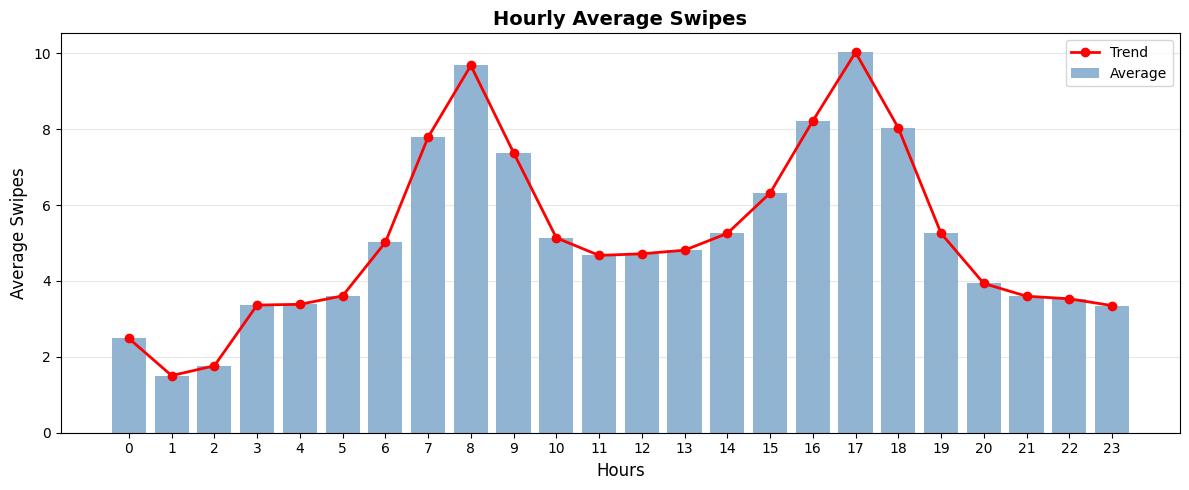

In [7]:
# my plotting code prefers the below implementation
hourly_avg_swipes = df.groupby("hour")["swipes"].mean()
plot_seasonality(hourly_avg_swipes, "Hourly Average Swipes", "Hours", "Average Swipes")


Note that 0 = Monday

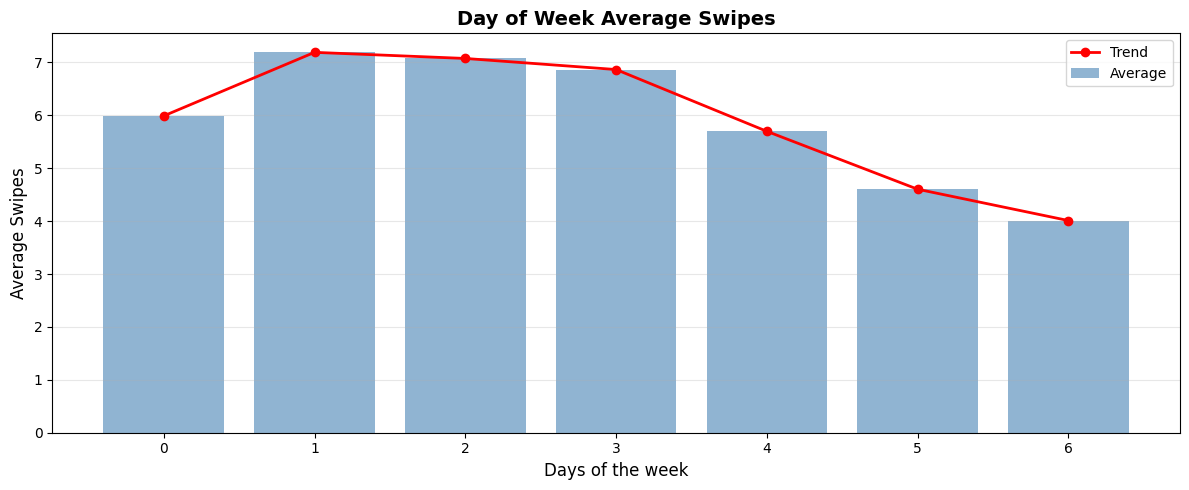

In [8]:
day_of_week_average_swipes = df.groupby("day_of_week")["swipes"].mean()
plot_seasonality(
    day_of_week_average_swipes,
    "Day of Week Average Swipes",
    "Days of the week",
    "Average Swipes",
)


OK so:

- Months are all pretty flat...not much variation based on average
- 8a & 5p are the most hectic hours as expected
- TWR are the most hectic days

Having said that, can we decompose that into an actionable set of 
insights based on the demand?

### How do we frame the problem?

The goal is to find the optimal distribution of cars in the BART
system, given the station-wise constraints and the demand.

Suppose $x_R$ and $x_G$ are the only variables we have at the 
start. 

Say we have 6 stations:

- Embarcadero
- Downtown Berkeley
- 12th St
- OAK
- SFO
- Fremont

Also suppose it's like

```
    SFO
     |
E -- D -- 12 -- F   <=== that's red line (right/left)
     |
    OAK             <=== that's green line (up/down)
```

We have 10 cars, and 2 lines. We want to minimize the number of 
cars running through the station, in a way that meets our demand:

We know the capacities:
- E-D
- E-12
- E-F
- E-SFO
- E-OAK
- D-SFO
- D-OAK
- D-12
- D-F
- D-E
... 36 total permutations. 

Suppose we know the capacities like this table:

| From     | To       | Line     | Demand   | 
| -------- | -------- | -------- | -------- |
| Embarc   | Downtown | Red      | 10       | 
| Embarc   | Downtown | Green    | 0        |
| Embarc   | 12       | Red      | 25       |
... and so on

We have 200 cars. We want to figure out how many cars to assign
to Red line and Green line based on this demand

Let's actually set a variable to determine how many cars are 
assigned to a particular `From <-> To` combination: $u_{f,t,l}$

If there is a connection on a specific line between two 
stations, then $u_{f,t,l} = 1$, otherwise 0.

Now, we'll have some additiol constraints, based on the nature of
train travel. For example, you **cannot** have 4 cars be between
two stations, and then three cars be the case on the next stop.

Based on the simplified diagram, it would be:

E -- D -- 12 -- F   <=== that's red line (right/left)

1. $u_{E, D, Red} = u_{D, 12, Red} = u_{12, F, Red}$

Essentially, the number of cars assigned to (Embarcadero -> 
Downtown Berkeley) **must equal** number of cars assigned to
(Downtown Berkeley -> 12th St), which must equal the number of
cars assigned to (12th Street -> Fremont). So, in a specific 
direction, the number cars along that direction **must be equal**

In this framing of the problem, we're still interested in the 
optimal number of cars that need to be assigned to each line. 

2. If the demand of a certain pair of station must be so much, then the $u_{f, t, l} \le
C$ for that value $C$ derived from the demand

## Maximization

In this context, we are trying to maximize the sum across all station pairs for a 
given color. 

$$
\sum_{f, t} u_{l}
$$

So for all the $u_{Red}$, sum all the station pairs. But this breaks down since u would
be a decision variable. What am I missing?